# Exploring Maritime Activities and the S\&P 500

This notebook examines the relationship between AIS maritime traffic and the S\&P 500 index prices. The analysis is organized into four main steps:

1. **Data Collection**
2. **Data Cleaning**
3. **Data Analysis**
4. **Presentation**

---

## Table of Contents

1. [Project Overview](#project-overview)
2. [Installation and Setup](#installation-and-setup)
3. [Database Connection](#database-connection)
4. [Data Loading](#data-loading)
5. [Dataframe Summaries](#dataframe-summaries)
6. [Helper Functions](#helper-functions)
7. [Main Analysis and Visualizations](#main-analysis-and-visualizations)
8. [Subset Analysis](#subset-analysis)
9. [Conclusion](#conclusion)

---

## 1. Project Overview <a class="anchor" id="project-overview"></a>

We explore how daily vessel counts derived from AIS (Automatic Identification System) data correlate with the daily and monthly close prices of the S\&P 500 index. The workflow is:

* **AIS Processor**: Downloads, cleans, and filters seven days of AIS data at a time, removes duplicates and non-commercial vessels, maps each vessel to its nearest port, and stores the cleaned data.
* **Financial Fetcher**: Uses `yfinance` to retrieve historical closing prices for the S\&P 500 (^GSPC) and individual components, scraping the current ticker list from Wikipedia.
* **Database Storage**: Saves cleaned datasets in a PostgreSQL database for efficient querying and reproducibility.
* **Pipeline Class**: Encapsulates all data retrieval, cleaning, and storage logic.

---

## 2. Installation and Setup <a class="anchor" id="installation-and-setup"></a>

In [1]:
# Create and activate a virtual environment (optional)
# python -m venv .venv && source .venv/bin/activate

!pip install -r requirements.txt




[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from Pipeline.pipeline import Pipeline
import seaborn as sns

## 3. Database Connection <a class="anchor" id="database-connection"></a>

Configure and connect to the PostgreSQL database where cleaned data tables are stored:

In [3]:
db_config = {
    "user": "ais_sp500_db_user",
    "password": "lFmNQ7l0yiXhSc1Bet3OHw8EuUeDuv7F",
    "host": "dpg-d0rflvndiees73c05ea0-a.oregon-postgres.render.com",
    "port": 5432,
    "database": "ais_sp500_db"
}

# Initialize the pipeline
pipeline = Pipeline(db_config=db_config)

## 4. Data Loading <a class="anchor" id="data-loading"></a>

Load cleaned tables from the database and save locally if needed:


In [4]:
# Load AIS port visits
ais_port_visits = pipeline.load_data("ais_port_visits")
ais_port_visits.to_csv("ais_port_visits.csv", index=False)

# Load port-level financial data
ais_port_financial = pipeline.load_data("ais_port_financial_data_db")
ais_port_financial.to_csv("ais_port_financial_data.csv", index=False)

# Load daily S&P 500 macro data
yfinance_macro = pipeline.load_data("macro_prices")
yfinance_macro.to_csv("yfinance_macro_data.csv", index=False)

Loading data from PostgreSQL table: ais_port_visits
Data loaded successfully from ais_port_visits (records: 129959)
Loading data from PostgreSQL table: ais_port_financial_data_db
Data loaded successfully from ais_port_financial_data_db (records: 217056)
Loading data from PostgreSQL table: macro_prices
Data loaded successfully from macro_prices (records: 476)



| Column             | Description                                          |
| ------------------ | ---------------------------------------------------- |
| `MMSI`             | Unique vessel identifier                             |
| `BaseDateTime`     | Timestamp of the AIS message                         |
| `LAT`, `LON`       | Latitude and longitude of the vessel                 |
| `VesselType`       | Numeric code for vessel type                         |
| `Status`           | Navigational status (e.g., "Under way", "At anchor") |
| `TransceiverClass` | Transponder class (A = commercial, B = pleasure)     |
| `Port_Name`        | Nearest port determined by geospatial 

In [5]:
ais_port_visits.head()

,MMSI,BaseDateTime,LAT,LON,VesselType,Status,TransceiverClass,Port_Name
0,205700000,2020-01-01 00:01:05,33.74967,-118.20893,70.0,5.0,A,Los Angeles
1,205706000,2020-01-01 00:01:07,28.93657,-95.33370,80.0,5.0,A,Houston
2,209513000,2020-01-01 00:00:48,26.08783,-80.11618,70.0,5.0,A,Miami
3,210737000,2020-01-01 00:01:47,30.06448,-90.87478,70.0,5.0,A,New Orleans
4,210998000,2020-01-01 00:01:31,29.74722,-95.11249,70.0,5.0,A,Houston


## 6. Helper Functions <a class="anchor" id="helper-functions"></a>

Define reusable functions for charting and merging datasets:

In [41]:
def generate_sp500_chart(df):
    # Generate a line chart for S&P 500 prices using plotly
    plt.figure()
    plt.plot(df['Date'], df['^GSPC_Close'], label='S&P 500 Close', color='blue')
    plt.title('S&P 500 Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('S&P 500 Close Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Merge daily vessel counts with S&P 500 prices and aggregate monthly
def prepare_monthly_summary(vessels, prices):
    vessels['Date'] = pd.to_datetime(vessels['BaseDateTime']).dt.date
    prices['Date'] = pd.to_datetime(prices['Date']).dt.date

    daily_counts = (
        vessels
        .groupby('Date')
        .size()
        .reset_index(name='Vessel_Count')
    )

    daily_prices = (
        prices[['Date', '^GSPC_Close']]
        .groupby('Date', as_index=False)
        .mean()
    )

    merged = pd.merge(daily_counts, daily_prices, on='Date', how='inner')
    merged['Date'] = pd.to_datetime(merged['Date'])
    merged['Month'] = merged['Date'].dt.to_period('M').dt.to_timestamp()

    monthly = (
        merged
        .groupby('Month').agg({
        'Vessel_Count': 'sum',
        '^GSPC_Close': 'mean'
    }).reset_index()
    )

    print(monthly.columns)
    return merged, monthly

# Compute and print lagged month correlations
def print_lagged_correlations(monthly, max_lag=6):
    for lag in range(1, max_lag+1):
        monthly[f'Vessel_Count_Lag_{lag}'] = monthly['Vessel_Count'].shift(lag)
            # drop nan
    monthly = monthly.dropna(subset=[f'Vessel_Count_Lag_1'])
        

    print("Lagged Correlations (Vessel Count → S&P 500):")
    for lag in range(1, max_lag+1):
        corr = monthly[[f'Vessel_Count_Lag_{lag}', '^GSPC_Close']].corr().iloc[0, 1]
        print(f"  Lag {lag}: {corr:.3f}")
    
# Plot correlation trends
def plot_correlation_trends(monthly, max_lag=6):
    stats = [
        monthly[[f'Vessel_Count_Lag_{lag}', '^GSPC_Close']].corr().iloc[0, 1]
        for lag in range(1, max_lag+1)
    ]
    plt.figure()
    plt.plot(range(1, max_lag+1), stats, marker='o')
    plt.title('Lagged Correlation: Vessel Count vs S&P 500')
    plt.xlabel('Lag (months)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()

# Plot lagged vessel count vs Avg S&P 500 side by side
def plot_bar_vessel_lag(monthly_lagged):
    # ignore first month since it has no lagged value
    monthly_lagged = monthly_lagged[monthly_lagged['Month'] >= monthly_lagged['Month'].min() + pd.DateOffset(months=1)]
    
    # Plot
    bar_width = 0.4
    x = np.arange(len(monthly_lagged))

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Bar 1: Lagged Vessel Count
    ax1.bar(x - bar_width/2, monthly_lagged['Vessel_Count_Lag_1'], width=bar_width, color='skyblue', label='Lagged Vessel Count')
    ax1.set_ylabel('Vessel Count (Lagged)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')

    # Bar 2: Avg S&P 500
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width/2, monthly_lagged['^GSPC_Close'], width=bar_width, color='orange', label='Avg S&P 500')
    ax2.set_ylabel('S&P 500 Close', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # X-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(monthly_lagged['Month'].dt.strftime('%Y-%m'), rotation=45, ha='right')

    # Title and layout
    plt.title('Lagged Vessel Count (1-Month Ahead) vs Avg S&P 500')
    fig.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Plot regression between lagged vessel count and current S&P 500
def plot_count_sp500_reg(monthly_lagged):
    #drop rows with NaN values
    monthly_lagged = monthly_lagged.dropna(subset=['Vessel_Count_Lag_1', '^GSPC_Close'])
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='Vessel_Count_Lag_1',
        y='^GSPC_Close',
        data=monthly_lagged,
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'black'},
        ci=95
    )

    plt.title('Lagged Correlation (1 Month): Vessel Count vs S&P 500')
    plt.xlabel('Lagged Vessel Count (Previous Month)')
    plt.ylabel('S&P 500 Close (Current Month)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## 7. Main Analysis and Visualizations <a class="anchor" id="main-analysis-and-visualizations"></a>

Load and visualize the full dataset:

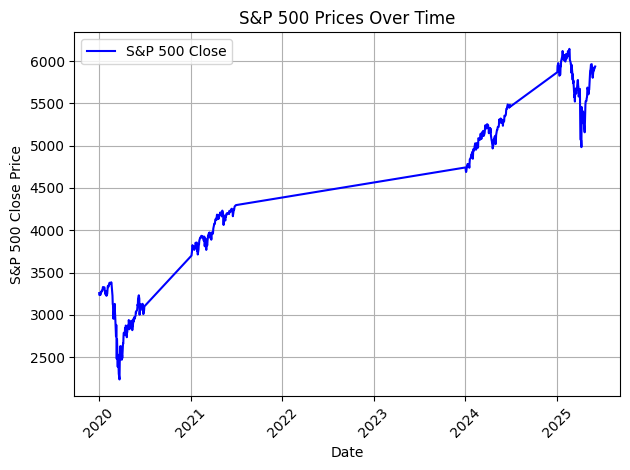

None

Index(['Month', 'Vessel_Count', '^GSPC_Close'], dtype='object')


In [42]:
# Ensure datetime format
prices = yfinance_macro.copy()
prices['Date'] = pd.to_datetime(prices['Date'])

# Generate interactive index chart
display(generate_sp500_chart(prices))

# Prepare merged data
full_merged, full_monthly = prepare_monthly_summary(ais_port_visits, yfinance_macro)


### Lagged Correlation: Vessel Count vs S&P 500


Lagged Correlations (Vessel Count → S&P 500):
  Lag 1: 0.792
  Lag 2: 0.730
  Lag 3: 0.714
  Lag 4: 0.666
  Lag 5: 0.552
  Lag 6: 0.433
Index(['Month', 'Vessel_Count', '^GSPC_Close', 'Vessel_Count_Lag_1',
       'Vessel_Count_Lag_2', 'Vessel_Count_Lag_3', 'Vessel_Count_Lag_4',
       'Vessel_Count_Lag_5', 'Vessel_Count_Lag_6'],
      dtype='object')


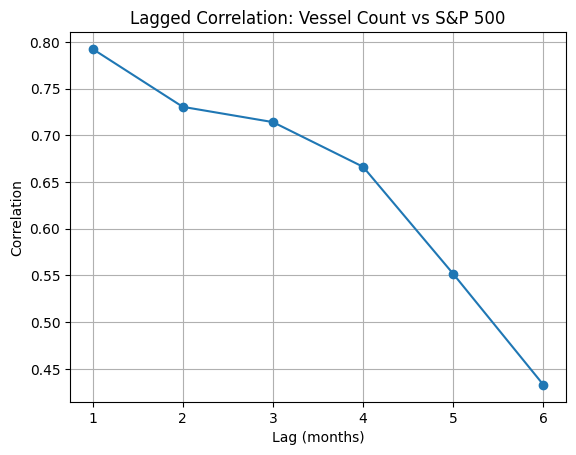

In [43]:
# Compute correlations
print_lagged_correlations(full_monthly)
print(full_monthly.columns)

# Plot correlation trends
plot_correlation_trends(full_monthly)

The plot shows the correlation between monthly vessel traffic (lagged) and the S&P 500 index over lags of 1 to 6 months:


- **Lag 1 (≈ 0.79)**  
  The strongest relationship: vessel counts from one month prior explain nearly 60 % of the variance in that month’s S&P 500 levels.

- **Lags 2–4 (≈ 0.73 → 0.67)**  
  Correlation declines gradually but remains substantial through a 3–4 month horizon.

- **Lags 5–6 (≈ 0.55 → 0.43)**  
  Beyond a quarter ahead, the predictive power weakens more sharply.

---

#### Interpretation

1. **Short-Term Lead**  
   Vessel traffic is a very strong leading indicator at a 1-month lag.  
2. **Diminishing Signal**  
   Predictive power decays steadily—by 6 months it’s much weaker.  
3. **Economic Rationale**  
   Marine freight volumes likely presage trade, production, and supply‐chain activity, which feed into equity market sentiment on a 1–2 month cycle.  

**Bottom Line:**  
Use vessel‐count data primarily for 1–2 month market forecasts—its utility tapers off at longer horizons.  


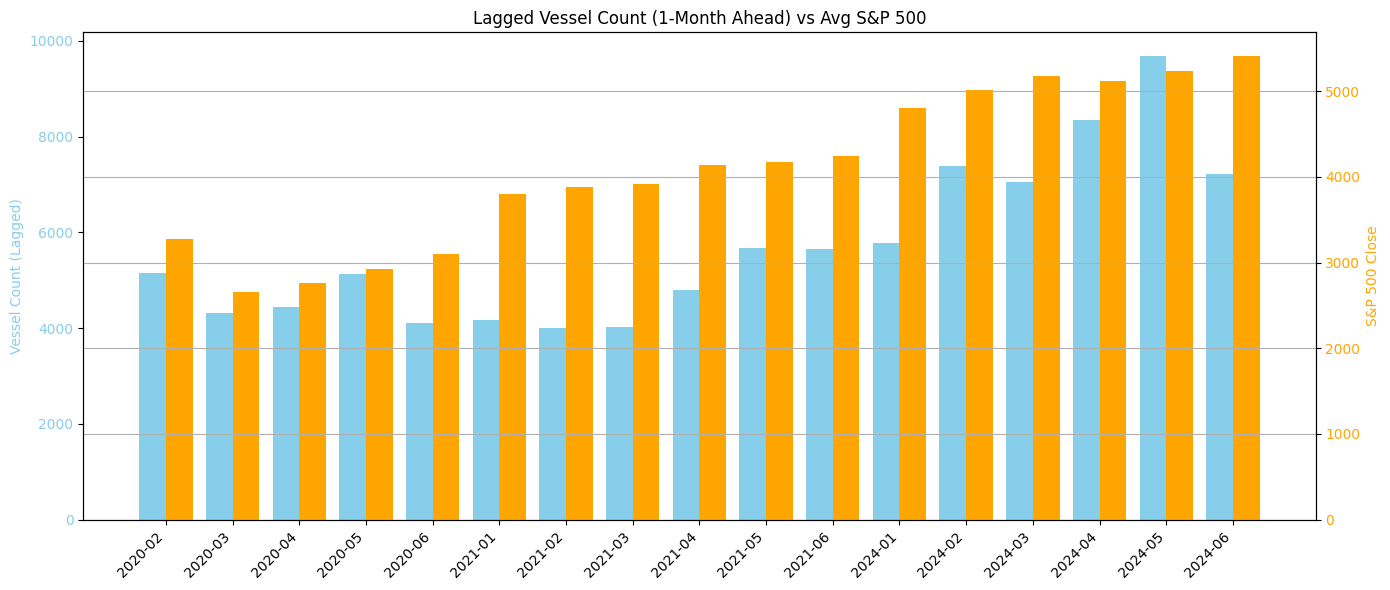

In [44]:
#plot bar chart of lagged vessel count vs S&P 500
plot_bar_vessel_lag(full_monthly)



The dual‐axis bar chart vividly shows how the 1-month-lagged vessel counts (blue bars, left axis) and the contemporaneous average S&P 500 closing levels (orange bars, right axis) both trend upward over the sample period, and how their month-to-month movements tend to align:

- **Steady Growth Over Time**
    From early 2020 through mid-2024, both vessel traffic (lagged) and the S&P 500 rise substantially—vessel counts go from ~4,000–5,000 up to near 10,000, while the index climbs from ~3,000 to over 5,000.

- **Parallel Month-to-Month Swings**
    Noticeable jumps in vessel activity (e.g., early 2021 and early 2024) correspond with spikes in the index one month later. Conversely, dips or plateaus in shipping are mirrored by flatter S&P performance.

- **Magnitude Differences**
    Although the two series use different scales, the visual spacing of bars suggests that increments in vessel count often precede roughly proportional changes in the index. For example, the large increase from 2023-12 to 2024-01 in shipping (blue) precedes a large jump in the S&P (orange).

- **Consistency of the Leading Signal**
    The fact that the blue series is lagged by one month yet still “lines up” with the orange bars indicates shipping really may be a leading indicator. Even when the S&P occasionally decouples (e.g., mid-2021 small divergence), the overall co-movement is strong.

**Bottom line:**

Higher port-level vessel traffic one month prior tends to precede higher S&P 500 levels, supporting the idea that changes in maritime trade volume can function as a real‐economy leading signal for equity market dynamics.

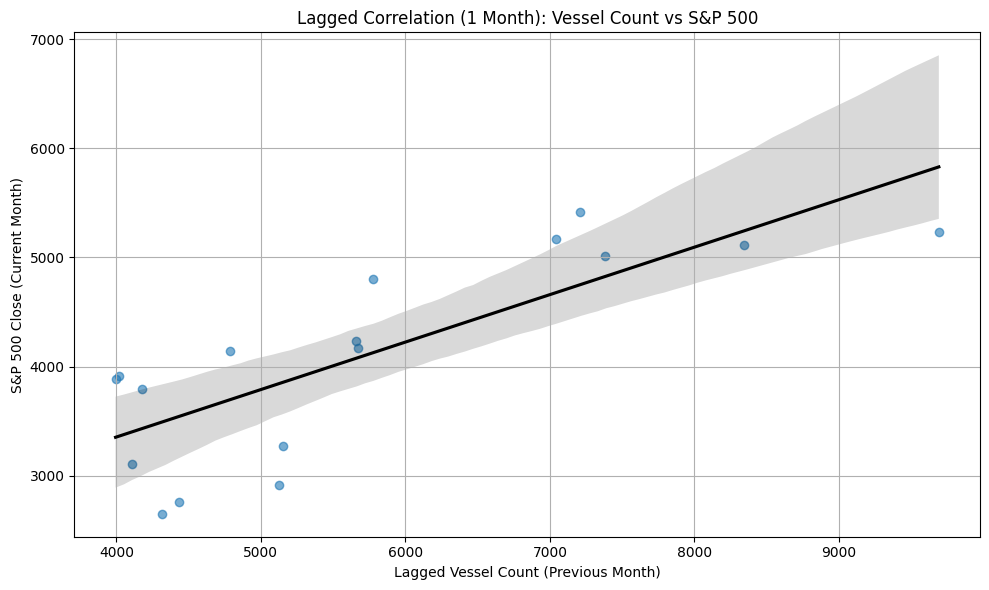

In [45]:
# Plot regression between lagged vessel count and current S&P 500
plot_count_sp500_reg(full_monthly)

### Lagged Correlation (1 Month) — Vessel Count vs S&P 500

This plot shows the relationship between:

- X-axis: Vessel traffic from the previous month
- Y-axis: Average S&P 500 Close in the current month

#### What the plot tells us:

- **Positive Correlation:** The upward slope of the regression line indicates that higher vessel traffic in one month tends to precede higher S&P 500 levels the next month.

- **Moderate to Strong Relationship:** The regression line fits the points with relatively tight confidence bounds, especially in the mid-range of vessel traffic values. This suggests the correlation is statistically meaningful.

- **Predictive Lag Makes Economic Sense:** Increased maritime traffic may signal higher trade volume, manufacturing output, and supply chain movement — all of which could fuel economic optimism reflected in equity markets like the S&P 500. The 1-month lag aligns with that timeline.

- **Outliers / Noise:** A few data points diverge from the trend, which is expected due to market noise, geopolitical shocks, or non-economic S&P 500 drivers (like interest rate policy). Still, the overall pattern holds.

#### Summary:

- Vessel traffic volume appears to lead S&P 500 movements by about 1 month
- The relationship is positive and visually strong
- Maritime trade could serve as a real-economy proxy for modeling market expectations

## 8. Subset Analysis <a class="anchor" id="subset-analysis"></a>

Perform the same analysis on selected time windows:

Index(['Month', 'Vessel_Count', '^GSPC_Close'], dtype='object')

=== Window: 2020-01-01 to 2020-07-01 ===


C:\Users\georg\AppData\Local\Temp\ipykernel_15284\3950006607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['Date'] = pd.to_datetime(prices['Date']).dt.date


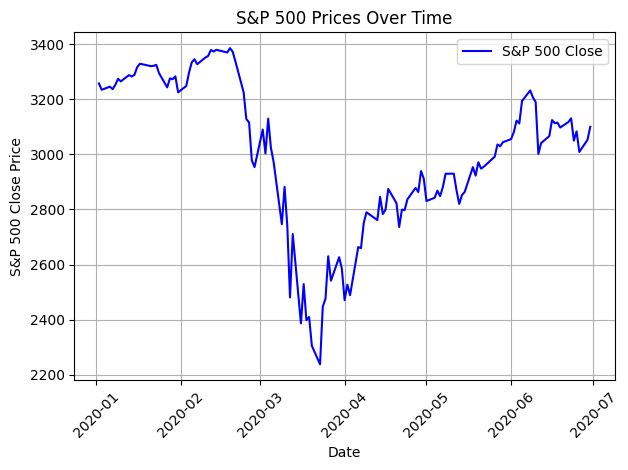

Lagged Correlations (Vessel Count → S&P 500):
  Lag 1: 0.425
  Lag 2: 0.124
  Lag 3: -0.761
  Lag 4: -1.000
  Lag 5: nan
  Lag 6: nan


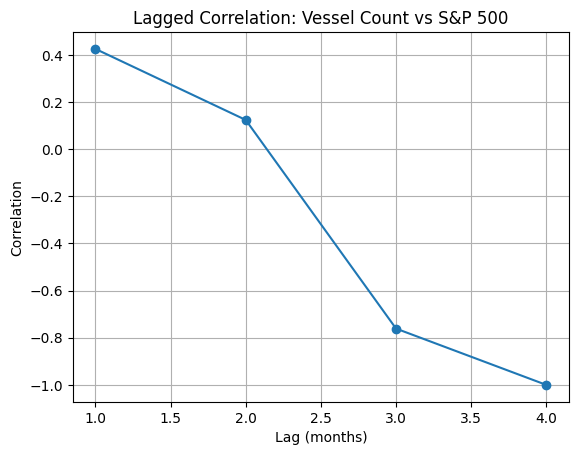

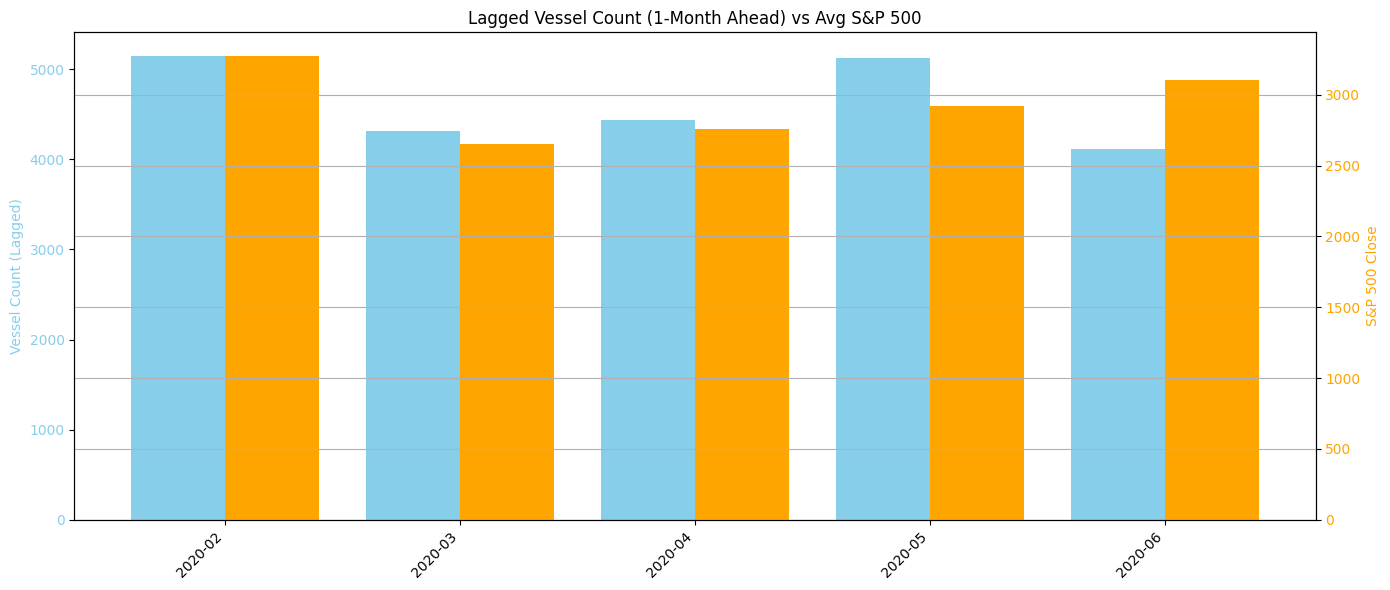

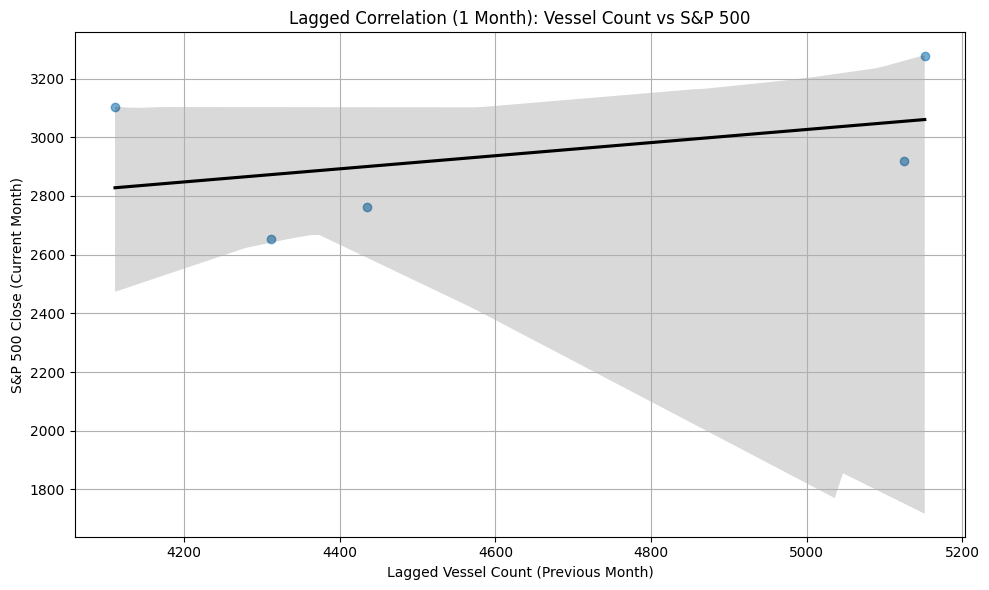

Index(['Month', 'Vessel_Count', '^GSPC_Close'], dtype='object')

=== Window: 2021-01-01 to 2021-07-01 ===


C:\Users\georg\AppData\Local\Temp\ipykernel_15284\3950006607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['Date'] = pd.to_datetime(prices['Date']).dt.date


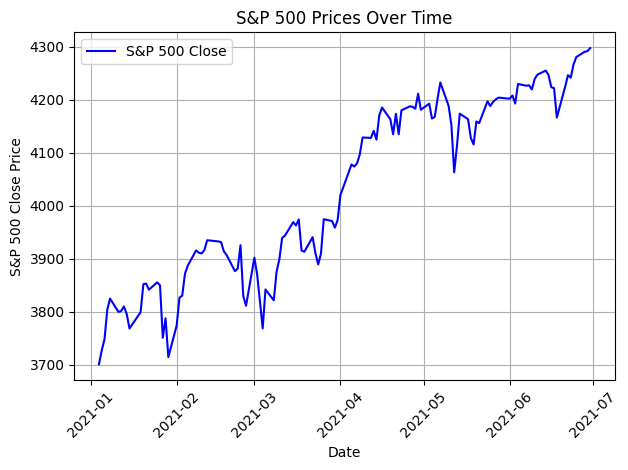

Lagged Correlations (Vessel Count → S&P 500):
  Lag 1: 0.945
  Lag 2: 0.741
  Lag 3: 0.970
  Lag 4: 1.000
  Lag 5: nan
  Lag 6: nan


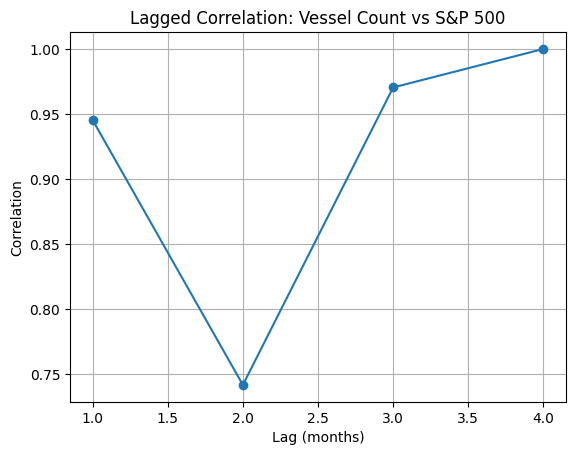

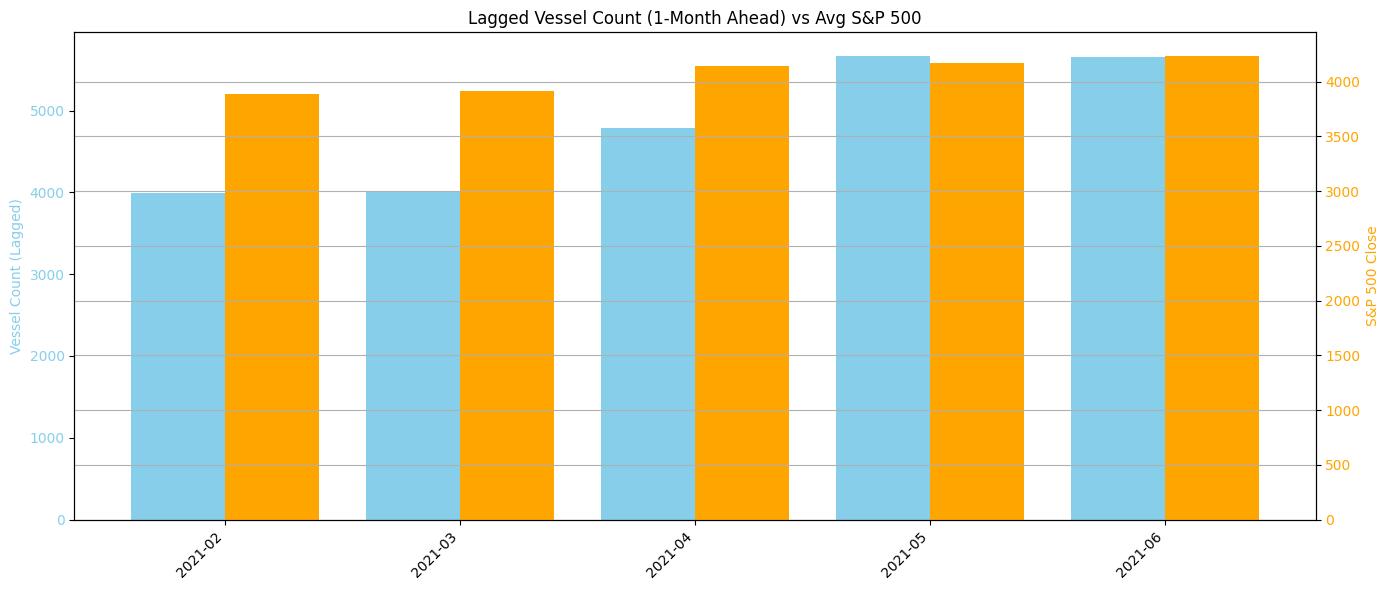

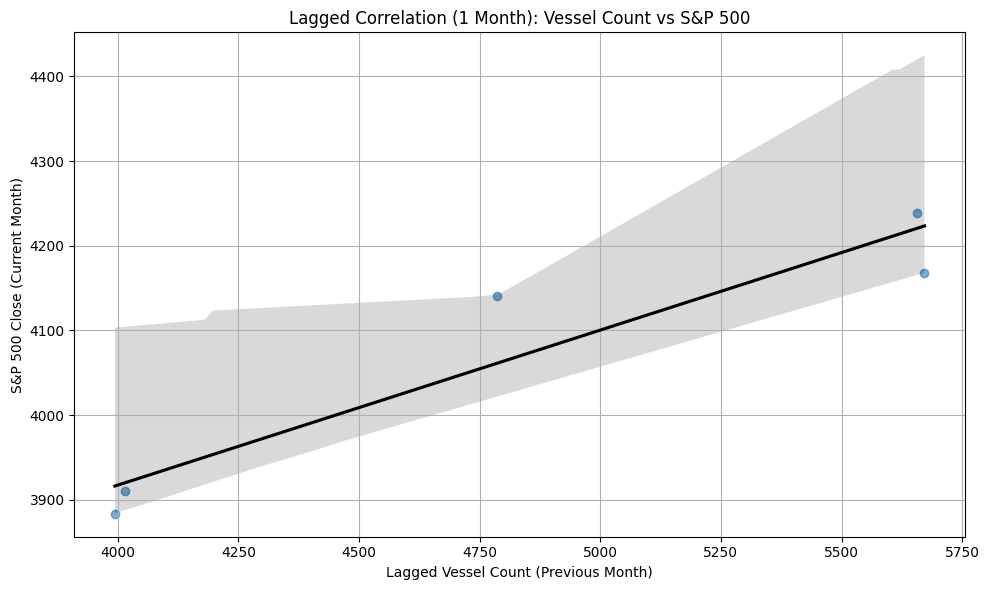

Index(['Month', 'Vessel_Count', '^GSPC_Close'], dtype='object')

=== Window: 2024-01-01 to 2024-07-01 ===


C:\Users\georg\AppData\Local\Temp\ipykernel_15284\3950006607.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['Date'] = pd.to_datetime(prices['Date']).dt.date


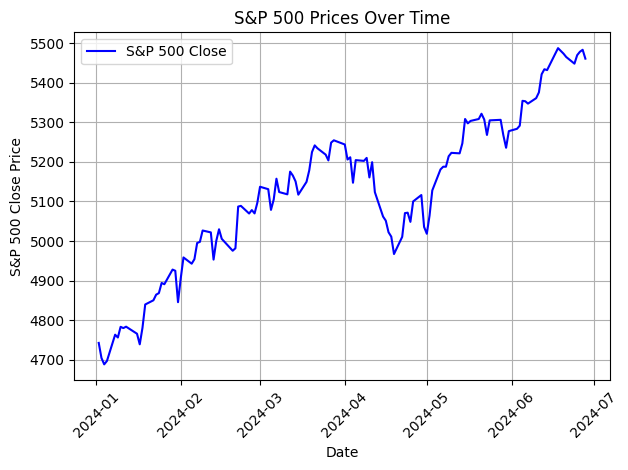

Lagged Correlations (Vessel Count → S&P 500):
  Lag 1: 0.001
  Lag 2: 0.991
  Lag 3: 0.786
  Lag 4: -1.000
  Lag 5: nan
  Lag 6: nan


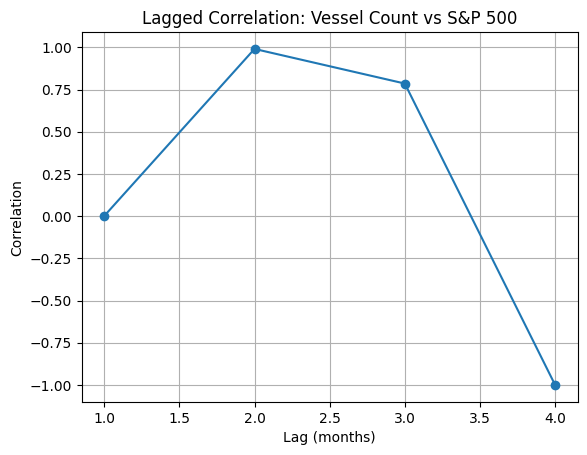

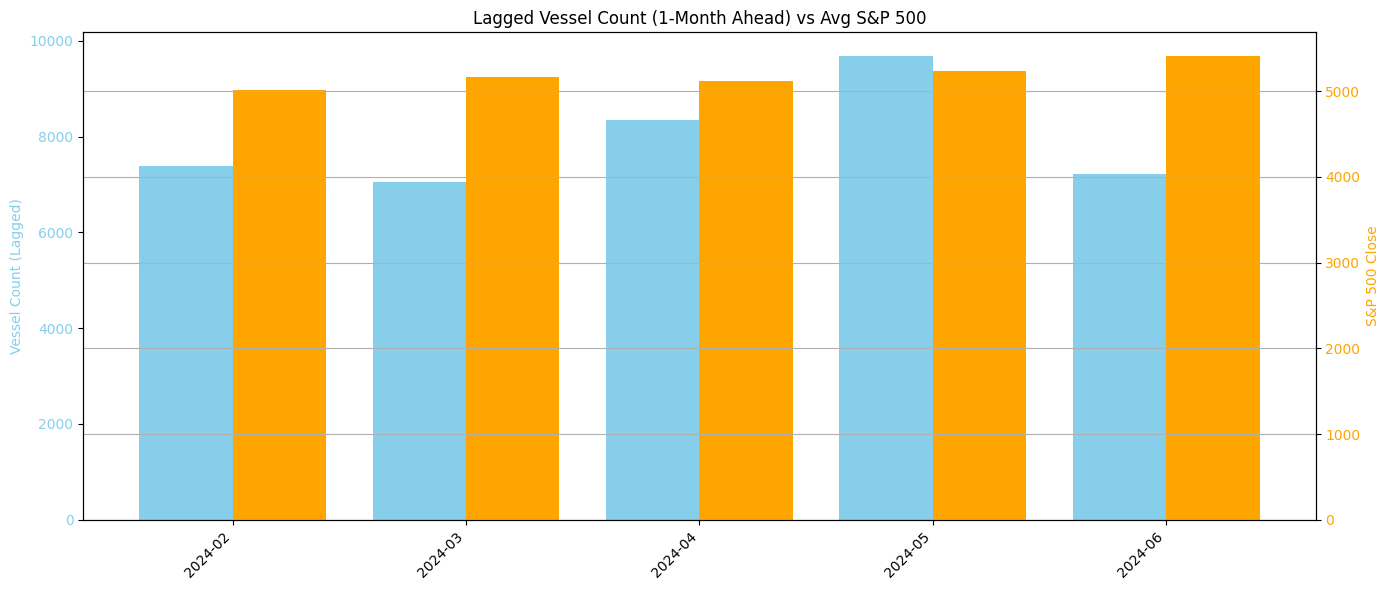

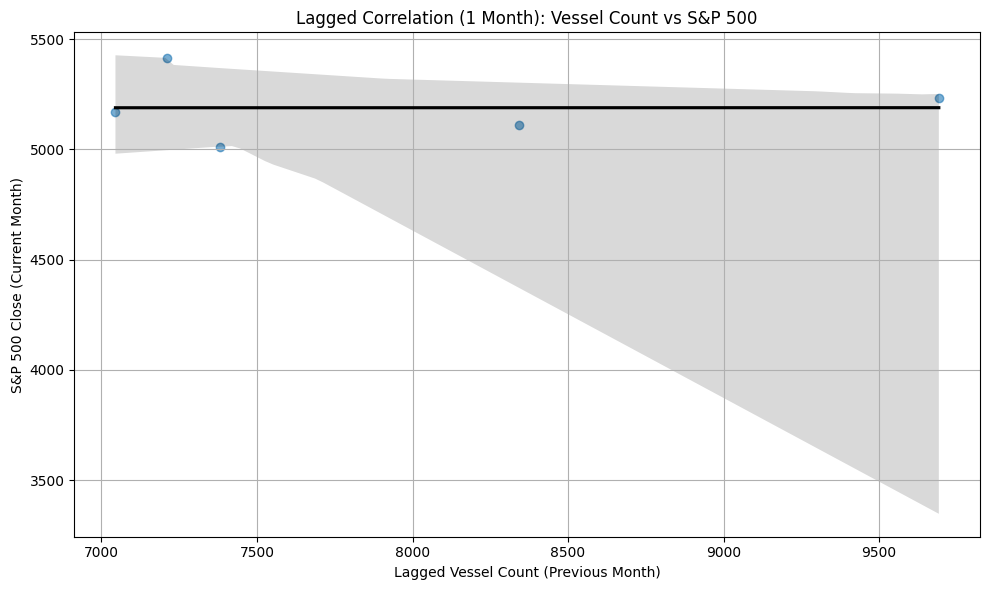

In [46]:
time_windows = [
    ("2020-01-01", "2020-07-01"),
    ("2021-01-01", "2021-07-01"),
    ("2024-01-01", "2024-07-01"),
    ("2025-01-01", "2025-07-01")
]

for start, end in time_windows[:-1]:  
    subset = prices[(prices['Date'] >= start) & (prices['Date'] <= end)]
    merged, monthly = prepare_monthly_summary(ais_port_visits, subset)

    print(f"\n=== Window: {start} to {end} ===")
    generate_sp500_chart(subset)
    print_lagged_correlations(monthly)
    plot_correlation_trends(monthly)
    plot_bar_vessel_lag(monthly)
    plot_count_sp500_reg(monthly)

### Key Observations:

- **More Noise at Subset Level:** Shorter windows introduce volatility: some lags flip sign or become undefined (NaN) when data is sparse.

- **Economic Factors Dominate:** In certain periods (e.g. 2021), broader market events (stimulus, policy shifts) weaken or reverse the shipping–market link.

- **Be Cautious with 1‑Month Lag:** While lag 1 often remains high, lag 2 in early windows occasionally exceeds lag 1. This suggests that exact timing can vary and should be interpreted with a pinch of salt.

## 9. Conclusion <a class="anchor" id="conclusion"></a>

This analysis demonstrates how variations in port-level vessel traffic correlate (with various lags) with the performance of the S&P 500 index. Further work could:

- Explore causality with additional economic indicators.

- Introduce more granular vessel attributes (e.g., cargo type).

- Introduce location specific insights using individual company data 

- Automate reports and dashboards for real-time monitoring.